<a href="https://colab.research.google.com/github/HebertMachado/data_science/blob/master/%5BPROJETO%5D_Classificador_de_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador de Fake News


Vivemos na era digital, onde a informação está mais acessível do que nunca, e continua ficando cada vez mais acessível, de forma mais ágil e ampla.

Apesar dos benefícios que isso traz, também existem problemas e riscos com isso. Aqui, vamos nos preocupar com um dos maiores deles: ***Fake News***
<p align=center>
  <img src="https://image.freepik.com/free-photo/woman-reading-newspaper_53876-13446.jpg" height="30%">
</p>

Com certeza você já se deparou com uma dessas. Em uma era de informação, a desinformação acaba sendo o nosso maior problema.

Em suma, ***Fake News*** são, como a tradução literal sugere, Notícias Falsas. Elas podem ir desde um número diferente em uma estatística apresentada, até a notícia de uma acontecimento completamente falso.

## Como isso influencia nossa vida?

Como de costume, nós tendemos a acreditar nos grandes veículos de mídia, ou de pessoas do nosso ciclo de amigos que nos encaminham notícias em redes sociais. Dessa forma, criamos o hábito de não checar nossas fontes, e assim, acreditamos e disseminamos notícias falsas, às vezes sem nem saber.

Isso se torna um grande problema quando afeta o resultado de algo importante no bem comum de nossa sociedade, como resultados de eleições, opinião pública sobre determinados projetos, políticas públicas, e até pessoas públicas, sejam elas do meio político, artístico, jornalístico, ou qualquer outro.

## O Projeto

Hoje em dia, podemos contar com ferramentas que nos ajudem a identificar e filtrar notícias falsas. Com técnicas de *Machine Learninr* como **Redes Neurais** essa tarefa de vasculhar diversas fontes de notícias para descobrir o que é falso e o que é factual fica mais fácil.

> O objetivo do projeto é treinar um modelo que seja capaz de classificar notícias, com a melhor acurácia possível, entre falsas ou factuais.

Para isso, usaremos a biblioteca ***Tensorflow*** para treinar Redes Neurais que façam esse trabalho por nós.

In [1]:
# importando os pacotes necessarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

# configurando o notebook
np.random.seed(42)
sns.set_style()

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')


In [2]:
# carregando e verificando os dados
df = pd.read_csv('https://www.dropbox.com/s/g9snf1eozls46kq/fake_news.csv?dl=1')

print(df.shape)
df.head()

(44898, 5)


,title,text,subject,date,Target
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",1
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",1
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",1
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",0
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",1


### Os Dados
Nosso conjunto de dados possui quase 45 mil linhas e 5 colunas, das quais temos:

* `title` - Título da notícia
* `text` - Texto da notícia
* `subject` - Assunto da notícia
* `date` - Data em que foi publicada
* `Target` que é nossa variável alvo e está dividida em:
  * True (Factual) = 0
  * Fake (Falsa) = 1

### Tratando os Dados

Aqui, estamos lidando com nossa linguagem natural em formato de `string`, então precisamos de alguns conhecimentos de NLP para tratar esses dados da melhor forma, para que possam ser passados ao nosso modelo com sucesso, e dessa forma, obtermos os resultados que desejamos.

In [3]:
# tratando do texto das notícias
import string
def clean_text (text):
    words = str(text).split()
    words = [i.lower() + " " for i in words]
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation))
    return words

df['text'] = df['text'].apply(clean_text)
df.head()

,title,text,subject,date,Target
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,donald trump s white house is in chaos ...,News,"July 21, 2017",1
1,Failed GOP Candidates Remembered In Hilarious...,now that donald trump is the presumptive...,News,"May 7, 2016",1
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,mike pence is a huge homophobe he suppo...,News,"December 3, 2016",1
3,California AG pledges to defend birth control ...,san francisco reuters california attorne...,politicsNews,"October 6, 2017",0
4,AZ RANCHERS Living On US-Mexico Border Destroy...,twisted reasoning is all that comes from...,politics,"Apr 25, 2017",1


Agora, o que precisamos é separar nossos dados em treino, validação e teste, para que possamos continuar a trilhar o caminho que nos leva ao modelo.

In [4]:
# separando os datasets em treino, validação e teste
from sklearn.model_selection import train_test_split

train, test = train_test_split(df)
train, validation = train_test_split(train, test_size = 0.2)
print('Entradas por Dataset')
print('Dataset de Treino:0',len(train), 'linhas.')
print('Dataset de Validação:', len(validation), 'linhas.')
print('Dataset de Teste:',len(test), 'linhas.')

Entradas por Dataset
Dataset de Treino:0 26938 linhas.
Dataset de Validação: 6735 linhas.
Dataset de Teste: 11225 linhas.


### Pré-Processamento de Strings - NLP

Aqui neste projeto estamos focando em ***Deep Learning*** e a implementação de **Redes Neurais**, por isso, não iremos nos extender em pré-processamento de Strings.

De qualquer forma, esse é um ponto importante do projeto. Aqui, basicamente o que queremos é simplificar o texto, para que seja mais fácil do nosso modelo processar e entender. Por isso, iremos utilizar uma técnica que se chama ***Tokenizing***.

Em suma, Tokenizing, ou Tokenização, em tradução livre, é um passo que separa longos textos de strings em pedaços de textos mais curtos, chamados de tokens.

<p align=center>
  <img src="https://www.kdnuggets.com/wp-content/uploads/text-tokens-tokenization-manning.jpg" height="30%">
</p>

Para ler mais sobre esse assunto e entender melhor os passos e parâmetros abaixo, deixarei links de referência [aqui](https://www.kdnuggets.com/2017/12/general-approach-preprocessing-text-data.html) e [aqui](https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html).

In [5]:
# preparando os dados para o modelo
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
trunc_type = "post"
pad_type = "post"
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train.text)
word_index = tokenizer.word_index

# aplicando técnicas tokenizing e padding
training_sequences = tokenizer.texts_to_sequences(np.array(train.text))
training_padded = pad_sequences(training_sequences,truncating=trunc_type, padding=pad_type)

max_length = len(training_padded[0])

validation_sequences = tokenizer.texts_to_sequences(np.array(validation.text))
validation_padded = pad_sequences(validation_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)

# criando arrays com inputs
x_train = np.copy(training_padded)
x_val = np.copy(validation_padded)
y_train = train['Target'].values
y_val = validation['Target'].values

In [6]:
# veriificando o tamanho dos arrays
print('Tamanho dos Arrays')
print('Treino: ', len(x_train), 'linhas.')
print('Resposta: ', len(y_train), 'linhas.')

Tamanho dos Arrays
Treino:  26938 linhas.
Resposta:  26938 linhas.


### Preparando, Instanciando e Treinando o Modelo

Agora que nossos dados estão prontos, é hora de ir ao que interessa.

Foi feito um RandomSearch para encontrar os melhores parâmetros, em um processo lento e externo a este notebook, e instanciado um modelo que usa os melhores parâmetros encontrados.

In [7]:
# instanciando e dando fit no modelo
model = tf.keras.Sequential ([
        tf.keras.layers.Embedding(vocab_size, (155), input_length=max_length),
        tf.keras.layers.Conv1D(16, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
                         metrics=['accuracy'])
history = model.fit(x_train, y_train, verbose = 2, epochs = 3, validation_data = (x_val, y_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=6)])


Epoch 1/3
842/842 - 1163s - loss: 0.1014 - accuracy: 0.9673 - val_loss: 0.0081 - val_accuracy: 0.9975
Epoch 2/3
842/842 - 1153s - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0039 - val_accuracy: 0.9988
Epoch 3/3
842/842 - 1152s - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0032 - val_accuracy: 0.9985


Os resultados são bem promissores, apesar de carecerem de uma maior investigação. No entanto, cumpriu o objetivo de demonstrar o poder das Redes Neurais.

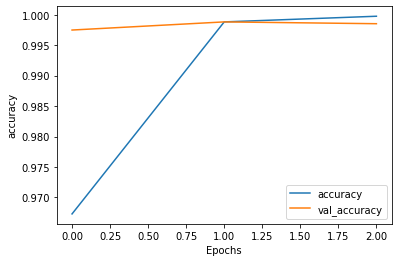

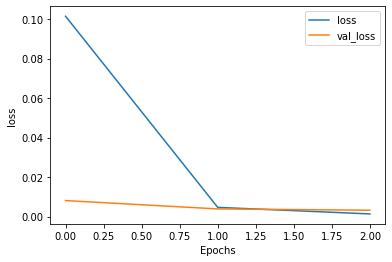

In [10]:
# visualizando os resultados
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Fazendo Previsões no Conjunto de Teste

Por fim, temos o pipeline ideal para tratar nossos dados, já treinamos, tunamos e obtivemos excelentes resultados em nosso conjunto de validação. Nosso modelo está pronto, mas ele tem mais uma missão a cumprir. 

Vamos apresentar dados completamente novos a ele, fazer previsõs e ver como ele se sai.

In [11]:
# tratando os dados de teste
test_sequences = tokenizer.texts_to_sequences(np.array(test.text))
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen = max_length)


In [12]:
# fazendo previsões
preds = np.round(model.predict(test_padded))

In [13]:
# conferindo o tamanho do resultado
len(preds)

11225

In [15]:
# verificando a acurácia
acc = np.sum(1 if i==j else 0 for i,j in zip(preds, test["Target"].values)) / len(test)
print("Accuracy:", acc)

Accuracy: 0.9985746102449888
